# Unstack the Flow

##### By: Ria Ysabelle Flora, James Bryan Labergas, Maria Angela Legaspi, and Elijah Justin Medina

## Executive Summary

With the emergence of Industry 4.0, there is an influx of online searches on how to get, process, and analyze data - with StackOverflow as one of the most popular platforms in addressing these questions.  The research aims to **answer the question on uncovering the underlying themes in the top posts about Python in StackOverflow in the last five years**. 

In accomplishing the research question, data was gathered from both the StackOverflow website (through web scraping) and the StackExchange data dump - summing up to a total of 18 million posted questions. This was further narrowed down to a total of 1.3 million posted questions pertaining to Python. From this, a random sample of 10K posts was used in determining the natural grouping of the topics. To prove the robustness of the random sampling, the Jaccard index of which was derived, which resulted to roughly 70%.

Term Frequency–Inverse Document Frequency (TF-IDF) on the post titles was used to vectorize the data. Truncated Singular Value Decomposition (TSVD) was further implemented for dimensionality reduction. Lastly, a two-fold clustering algorithm was implemented through the KMeans clustering method
    
   * **Level1:**  using numeric features
    
   * **Level2:** using thematic features. 
    
To summarize, Top "How To" topics in Python can be categorized into 5 namely: `Hot Post`, `Trending`, `S.O.S.`, `Curious Topics`, and `Spam`. The topics that were found in most of the 5 categories are `Pandas`, `NumPy`, `Django`, `Matplotlib`, and `String Processing`. There are topics that are endemic to one category like `Classes` but there are also those that are ubiquitous like `Django`

Results may aid students, enthusiasts, and academicians in targeting topics to focus on and further develop literature and programs to address the demand for these queries. 

## Table of Contents

1. Introduction
2. Data Description
3. Data Processing and Exploratory Data Analysis
    - Numerical features
    - Non-numerical features
4. Model
    - Numerical clustering
        - Dimensionality reduction
        - Clustering
    - Non-numerical clustering
        - TF-IDF vectorizer
        - Dimensionality reduction
        - Clustering
5. Resulting clusters and Insights
6. Conclusions and Recommendations

## Introduction

**Background on Stack Overflow**

StackOverflow is a platform owned by the StackExchange Network where students, professionals, and enthusiasts exchange information regarding programming through posts, queries, and comments. It also serves as a platform for programmers and businesses to collaborate and work on projects. 


With roughly 18 million posted questions, it is a comprehensive network of programmers across the field. Given this wide network of programmers, StackOverflow has been the ‘go to’ website for programmers to clarify and further understand programming algorithms and its syntax.

**Motivation of the study**

Anyone wishing to pursue a career in Data Science would have to master programming and any student of the Master of Science in Data Science (MSDS) program has at least visited StackOverflow once within the duration of the program. Given that the primary language used in class is Python, the group was particularly interested in looking into the data of StackOverflow. Aligning this interest with the projevct specifications, the group further established that primary purpose of the study is further illustrate the key areas of improvement in learning Python as a programming language. This would, hopefully, aid the program and its coordinators in further strengthening the curriculum design for MSDS for the upcoming batches. 


**Research problem**

The study wishes to exemplify and answer the research question:
    
    What are the themes of the top 'how to' questions about Python in StackOverflow in the last five years?

**Objectives of the study**

In answering the research question, the group shall accomplish the following:
- To gather data from StackOverflow and appropriately wrangle the given data for further analysis relative to the research problem
- To apply appropriate clustering algorithms in identifying the clustering of the the given data. Particularly, to cluster the data based on the numerical and non-numerical attributes of each StackOverflow post
- To draw insightful information based on the results of the implemented clustering

**Scope and delimitations**

Given the primary objectives of the study, the study is only focused towards questions pertaining to Python. The study is, however, delimited to questions posted within the span of 5 years (2014 - 2019). It is further narrowed down to questions pertaining to Python. 

In [1]:
#Preliminaries

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud

import requests
import time
from bs4 import BeautifulSoup
import sqlite3
import seaborn as sns
import re
import os
from functools import reduce

import psycopg2
from xml.etree import ElementTree

import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import clear_output

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

import sqlite3
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from PCA_and_Validation import cluster_range, plot_internal, PC_analysis

%matplotlib inline

## Data Description

The dataset used for this analysis is collected from the StackExchange archive: https://archive.org/details/stackexchange, which is a repository of the information within the StackExchange network in `XML` format. From the repository, the posts on StackOverflow for the `last 5 years` were gathered and stored into an SQL database (Appendix A.1). Each element on the XML file corresponds to a data entry on the SQL database while the columns of the database correspond to the attributes of the element.

The following attributes are extracted from each StackOverflow post: `Id`, `PostTypeId`, `AcceptedAnswerId`, `CreationDate`, `Score`, `ViewCount`, `Body`, `OwnerUserId`, `LastEditorUserId`, `LastEditDate`, `LastActivityDate`, `Title`, `Tags`, `AnswerCount`, `CommentCount`. Aside from the IDs which are the unique identifiers (integers) and the dates which are the timestamps, the other columns are:

- `Score` : difference of the number of upvotes and downvotes
- `ViewCount` : number of views on the post
- `Body` : post content including the code snippets
- `Title` : title of the post
- `Tags` : tags that qualify the post e.g. `python`, `c`
- `AnswerCount` : number of posts that answer the question post
- `CommentCount` : number of comments under the question post

Note that `Score`, `ViewCount`, `AnswerCount`, and `CommentCount` are all numerical attributes with integer values, `Body`, `Title`, and `Tags` are strings but the `Tags` have a smaller vocabulary size since the tags are categorical. The `PostTypeId` is an integer ranging from 1 to 8 where the common values are 1 corresponding to questions and 2 to answers.

Due to the size of the data, the posts were already filtered into only the questions (`PostTypeId=1`) upon loading into the database. As such, the database stores **18M** posted questions on StackOverflow.

## Data Processing and Exploratory Data Analysis

The focus of the problem is on the themes of Python questions. However, even after filtering `python` tags, **1.3M** Python questions remain. As such, sampling will be implemented in order to minimize the amount of posts to analyze.

However, sampling carries the risk of underrepresenting the dataset. As such, robustness tests were performed. Appendix B contains further details of the test but it is sufficient to know that the tests resulted in high similarities between the different sampled corpus. And so, we can proceed on analyzing 10000 sampled posts instead of the whole dataset. 

In [3]:
conn = sqlite3.connect('/mnt/processed/private/msds2020/lt13/database/stackoverflow.db')
cur = conn.cursor()
posts = []

cur.execute("""SELECT MAX(Id) FROM PostsQuestions
            WHERE Id LIKE '________'""")

max_id = int(cur.fetchall()[0][0])
idxs = list(range(max_id//1000))

while len(posts) < 1e4:
    idx = random.choice(idxs)
    # We want to minimize the number of iterations we have to go through to
    # sample while minimizing bias of consecutive posts. Per iteration, around
    # tens of samples are obtained.
    cur.execute(f"""SELECT DISTINCT * FROM PostsQuestions 
                WHERE tags LIKE "%python%"
                AND AcceptedAnswerId IS NOT NULL
                AND Id BETWEEN {idx*1000} AND {idx*1000+999}
                AND Id LIKE '{idx}___'""")
    posts.extend(cur.fetchall())
    idxs.remove(idx)

# Convert data to DataFrame
df_X0 = pd.DataFrame(posts, columns=['Id', 'PostTypeId', 'AcceptedAnswerId',
                                     'CreationDate', 'Score', 'ViewCount', 
                                     'Body', 'OwnerUserId',
                                     'LastEditorUserId', 'LastEditDate',
                                     'LastActivityDate', 'Title', 'Tags',
                                     'AnswerCount', 'CommentCount',
                                     'FavoriteCount', 'CommunityOwnedDate'])

The columns can be grouped into two categories: **numerical** and **non-numerical**.

### Numerical features

To easily visualize the relationships of the numerical features and their distribution, pairplots are utilized.

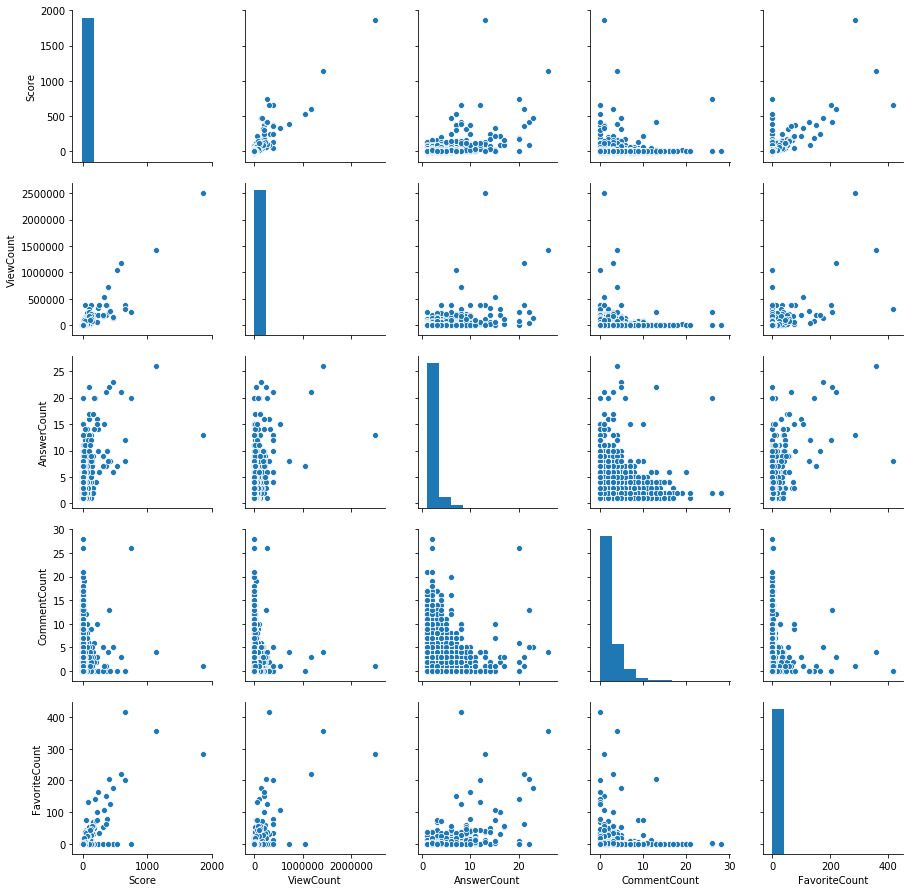

In [5]:
# Get the pairplot for the numerical features

X0_num = df_X0[['Score', 'ViewCount', 'AnswerCount',
                'CommentCount', 'FavoriteCount']].fillna(0).astype(int)
sns.pairplot(X0_num);

From the pairplots, there are no features that have a high correlation with each other. This observation tells us that we can use the features with little fear of overfitting.

Now looking at the distribution of values, three features stand out: `Score`, `ViewCount`, and `FavoriteCount`. Specifically, there are many posts with very low values for these three but there are also some posts with very, very high values for these features (from the large xlimits in the axis). In order to minimize this, log-scaling could be performed on these features.

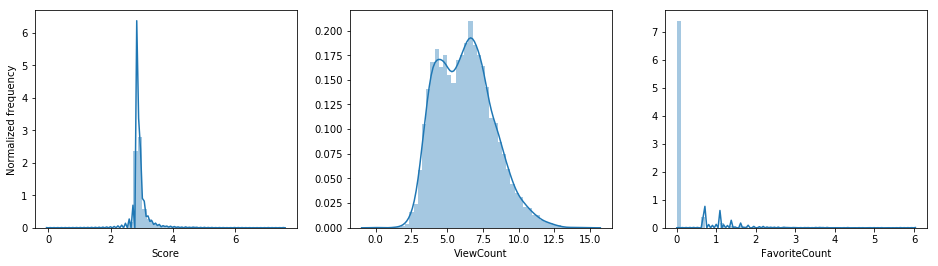

In [6]:
# Investigate effect of log-scaling the numerical features Score, ViewCount,
# and FavoriteCount

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
feats_log = ['Score', 'ViewCount', 'FavoriteCount']
for feat in feats_log:
    sns.distplot(X0_num[feat].apply(lambda x: np.log(x+1-X0_num[feat].min())), 
                 ax=ax[feats_log.index(feat)]);
ax[0].set_ylabel("Normalized frequency");

Log-scaling `Score` and `ViewCount` has improved their distribution of values. Taking a closer look at the features,

In [7]:
# Data description

X0_num.describe()

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
count,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000
mean,4.571543,4.894326e+03,1.930356,1.811151,0.783673
std,31.482968,3.859895e+04,1.559853,2.522866,8.821122
min,-16.000000,9.000000e+00,1.000000,0.000000,0.000000
25%,0.000000,1.160000e+02,1.000000,0.000000,0.000000
50%,1.000000,5.020000e+02,1.000000,1.000000,0.000000
75%,3.000000,1.870750e+03,2.000000,3.000000,0.000000
max,1860.000000,2.498414e+06,26.000000,28.000000,417.000000


Note that even up to the 75% quartile, `FavoriteCount` still has a value of 0, meaning most of the posts in the dataset has 0 number of users that favored the post. The non-zero proportion of the posts are small. Moreover, the distribution of the values are not bad (this was simply not apparent due to the high count at zero) and so it is not necessary to rescale the feature. As such, only the features `Score` and `ViewCount` will be log-scaled. 

In [8]:
# Process data into log-scaled data

X0_num['Score'] = X0_num['Score'].apply(lambda x: np.log(x+1-X0_num['Score'].min()))
X0_num['ViewCount'] = X0_num['ViewCount'].apply(lambda x: np.log(x+1))

Checking the features again,

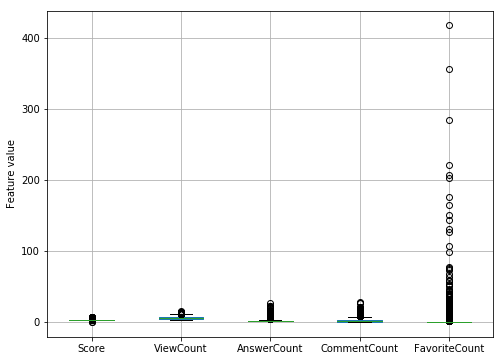

In [9]:
# Check the distributions of the different features
fig, ax = plt.subplots(figsize=(8,6))

X0_num.boxplot(ax=ax);
ax.set_ylabel('Feature value');

The values of each feature are not comparable to each other. And so, MinMaxScaler will be used.

In [10]:
# Rescale the features

Xnum_data = MinMaxScaler().fit_transform(X0_num.to_numpy())

### Non-numerical features

For each of the string features, `Title`, `Body`, and `Tags`, the most common words are identified. First is the simplest, `Tags`.

#### Tags

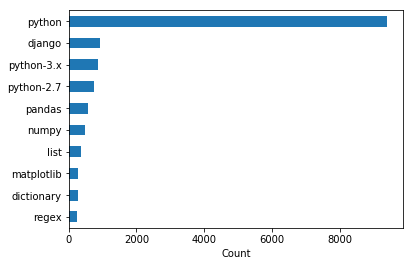

In [11]:
# Investigate the most common tags

tags = re.findall('<(.*?)>', ''.join(df_X0['Tags']))
fig, ax = plt.subplots()
df_str = pd.DataFrame(pd.Series(tags).value_counts(),
                      columns=['count']).head(10)[::-1]
df_str.plot.barh(ax=ax, legend=False);
ax.set_xlabel('Count');

Note that the filter on the posts apply to tags `python`, `python-3.x` and `python-2.7`. The most common tag, of course, is `python` since relatively fewer people qualify the version of the Python they are using. Other common tags are the commonly used libraries or functionalities in Python.

#### Title
Since the titles are composed of multiple words where some of them, unlike tags, are unnecessary, filtering the titles based on a vocabulary of stopwords is necessary.

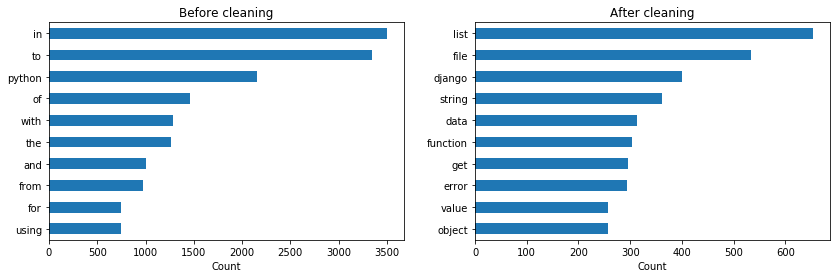

In [12]:
# For the title column:

# Get the words (at least two characters) and check the frequencies of words

titles = re.findall('\w{2,}', ''.join(df_X0['Title'].str.lower()))
fig, ax = plt.subplots(1, 2, figsize=(14,4))

df_str = pd.DataFrame(pd.Series(titles).value_counts(),
                      columns=['count']).head(10)[::-1]
df_str.plot.barh(ax=ax[0], legend=False);
ax[0].set_xlabel('Count');
ax[0].set_title('Before cleaning')

# Clean the data and check the common words again

stop_words = stopwords.words('english') + ['python', 'using', 'use']

titles_cleaned = [word for word in titles if word not in stop_words]

df_str = pd.DataFrame(pd.Series(titles_cleaned).value_counts(),
                      columns=['count']).head(10)[::-1]
df_str.plot.barh(ax=ax[1], legend=False);
ax[1].set_xlabel('Count');
ax[1].set_title('After cleaning');

The importance of stopwords can be seen from the top 10 common words in the corpus where the words in the uncleaned corpus lack interpretability.

#### Body

The body of the post contains the actual content of the question including the code snippets. The most frequent words for this are:

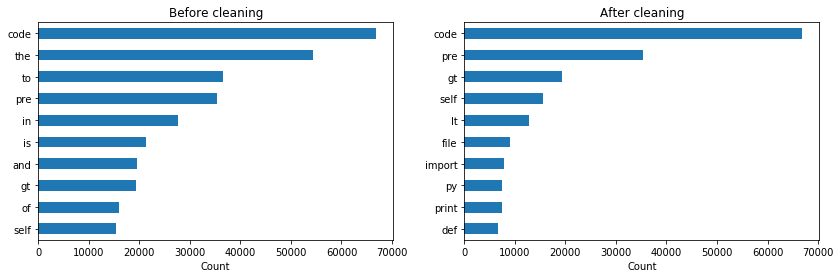

In [13]:
# For the body column:

# Get the words (at least two characters) and check the frequencies of words

bodies = re.findall('\w{2,}', ''.join(df_X0['Body'].str.lower()))
fig, ax = plt.subplots(1, 2, figsize=(14,4))

df_str = pd.DataFrame(pd.Series(bodies).value_counts(),
                      columns=['count']).head(10)[::-1]
df_str.plot.barh(ax=ax[0], legend=False);
ax[0].set_xlabel('Count');
ax[0].set_title('Before cleaning')

# Clean the data and check the common words again

stop_words = stopwords.words('english') + ['python', 'using', 'use']

bodies_cleaned = [word for word in bodies if word not in stop_words]

df_str = pd.DataFrame(pd.Series(bodies_cleaned).value_counts(),
                      columns=['count']).head(10)[::-1]
df_str.plot.barh(ax=ax[1], legend=False);
ax[1].set_xlabel('Count');
ax[1].set_title('After cleaning');

One observation from this is the high count values which when compared with `Title`, the `Body` will overwhelm the features from `Title`. While this can be remedied by normalizing for each document separately, a second observation where the top words in the `Body` are commands in Python that are excessively used like `print`, `def`, or `import`. As such, this does not give much context to the post. On account of both these observations and the number of features that will be added by using the `Body`, only `Title` and `Tags` are used as features in analysis of the non-numerical features.

## Model

Two sets of features are extracted: `numeric` and `non-numeric`. The groups of features describe different things. The numeric features describe the reach or awareness of the post and the interactions or engagements it has with other users. On the other hand, the non-numeric features characterize the context of the post, i.e. what it is about. Because of the two sets of features, two-layer clustering will be performed, first using the numeric features and second using the non-numeric.

### Numerical clustering

#### Dimensionality reduction
Now that we have our design matrix from the numerical features, dimensionality reduction is performed for visualization purposes. Since there are only 5 numerical features, clustering is still performed on the original dataset. The red lines indicate, on the left side, the elbow point and, on the right side, the 80% cumulative variance.

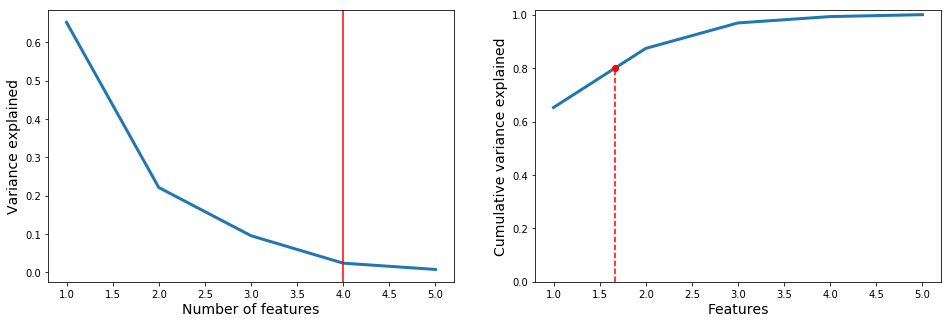

In [14]:
# Perform analysis of principal components on the variances.

PC_analysis(Xnum_data);

Using the standard of having $80\%$ of the variance captured, the design matrix will be truncated into 2 components (which can be easily visualized in 2D plots).

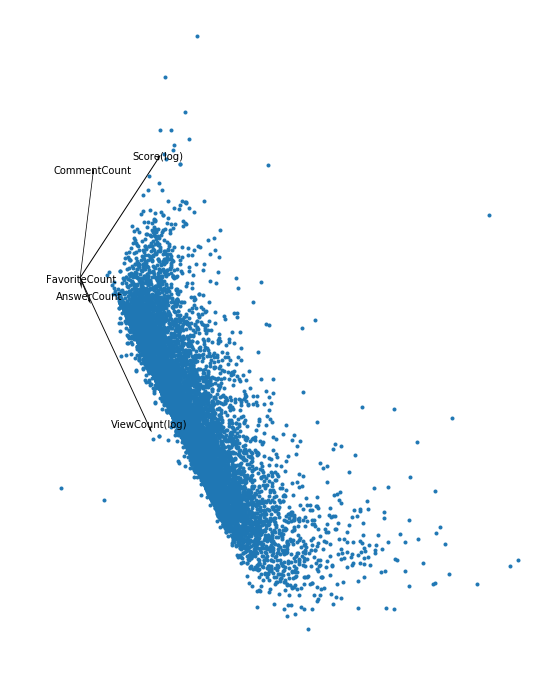

In [15]:
# Visualize the truncated data along with the directions of the original 
# features

pca = TruncatedSVD(n_components=2)
Xnum_trunc = pca.fit_transform(Xnum_data)
fig, ax1 = plt.subplots(figsize=(9, 12))
x0, y0 = 0.2, 0.2
s = 0.3
for feat, feat_name in zip(pca.components_.T, ['Score(log)', 'ViewCount(log)',
                                               'AnswerCount', 'CommentCount',
                                               'FavoriteCount']):
    ax1.arrow(x0, y0, s*feat[0], s*feat[1], color='k', width=.002, ec='none')
    ax1.text(x0+s*feat[0], y0+s*feat[1], feat_name, ha='center', color='k')
ax1.plot(Xnum_trunc[:, 0], Xnum_trunc[:, 1], '.')
ax1.axis('off');

Using TSVD, the first PC (x-axis) is a combination mainly of two features: Score and ViewCount, while the second PC is also a combination of these and CommentCount. The largest variability, though, is found along ViewCount. Other features like Score and CommentCount can be considered as the features perpendicular to this. From this, it is expected for clusters to form for different views and for different engagement/interaction levels (combination of Score, CommentCount).

#### Clustering

For this analysis, K-Means is used to cluster the stackoverflow questions based on their numerical features:

In [16]:
# Perform internal validations on different number of clusters to obtain the
# optimal number of clusters

k_start, k_stop = (2, 10)
kmeans_cluster = cluster_range(Xnum_data, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)  

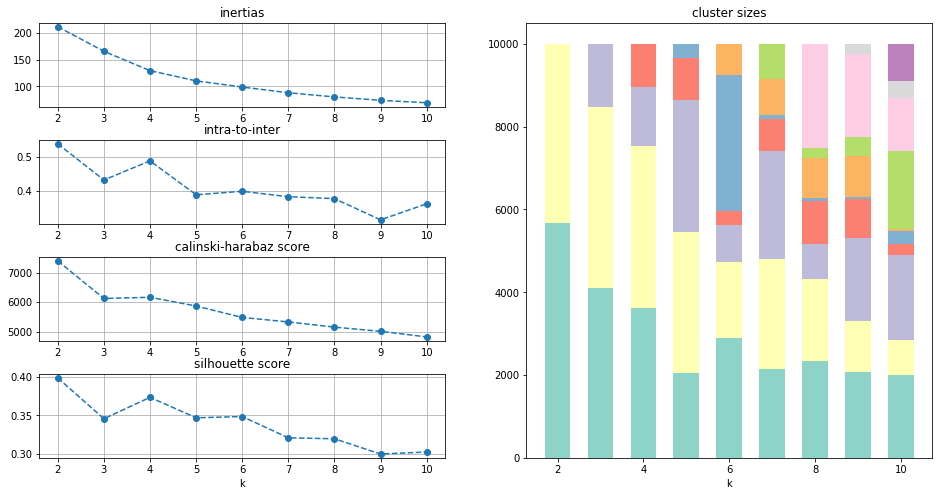

In [17]:
# Plot the resulting internal validation values

plot_internal(kmeans_cluster, k_start=k_start, k_stop=k_stop);

From the internal validations, taking into account the tradeoffs since we want low inertias, low intra-to-inter, high calinski-harabasz, and high silhouette, $k=5$ is chosen. The figure on the right shows the proportions of the clusters for different number of clusters. From these we could see how balanced the clusters are where for $k=5$ yields 4 clusters that have similar sizes and one that is small.

The resulting clusters can be qualified based on the level of viewership and engagement/interaction. These clusters are classified and named according to these features.

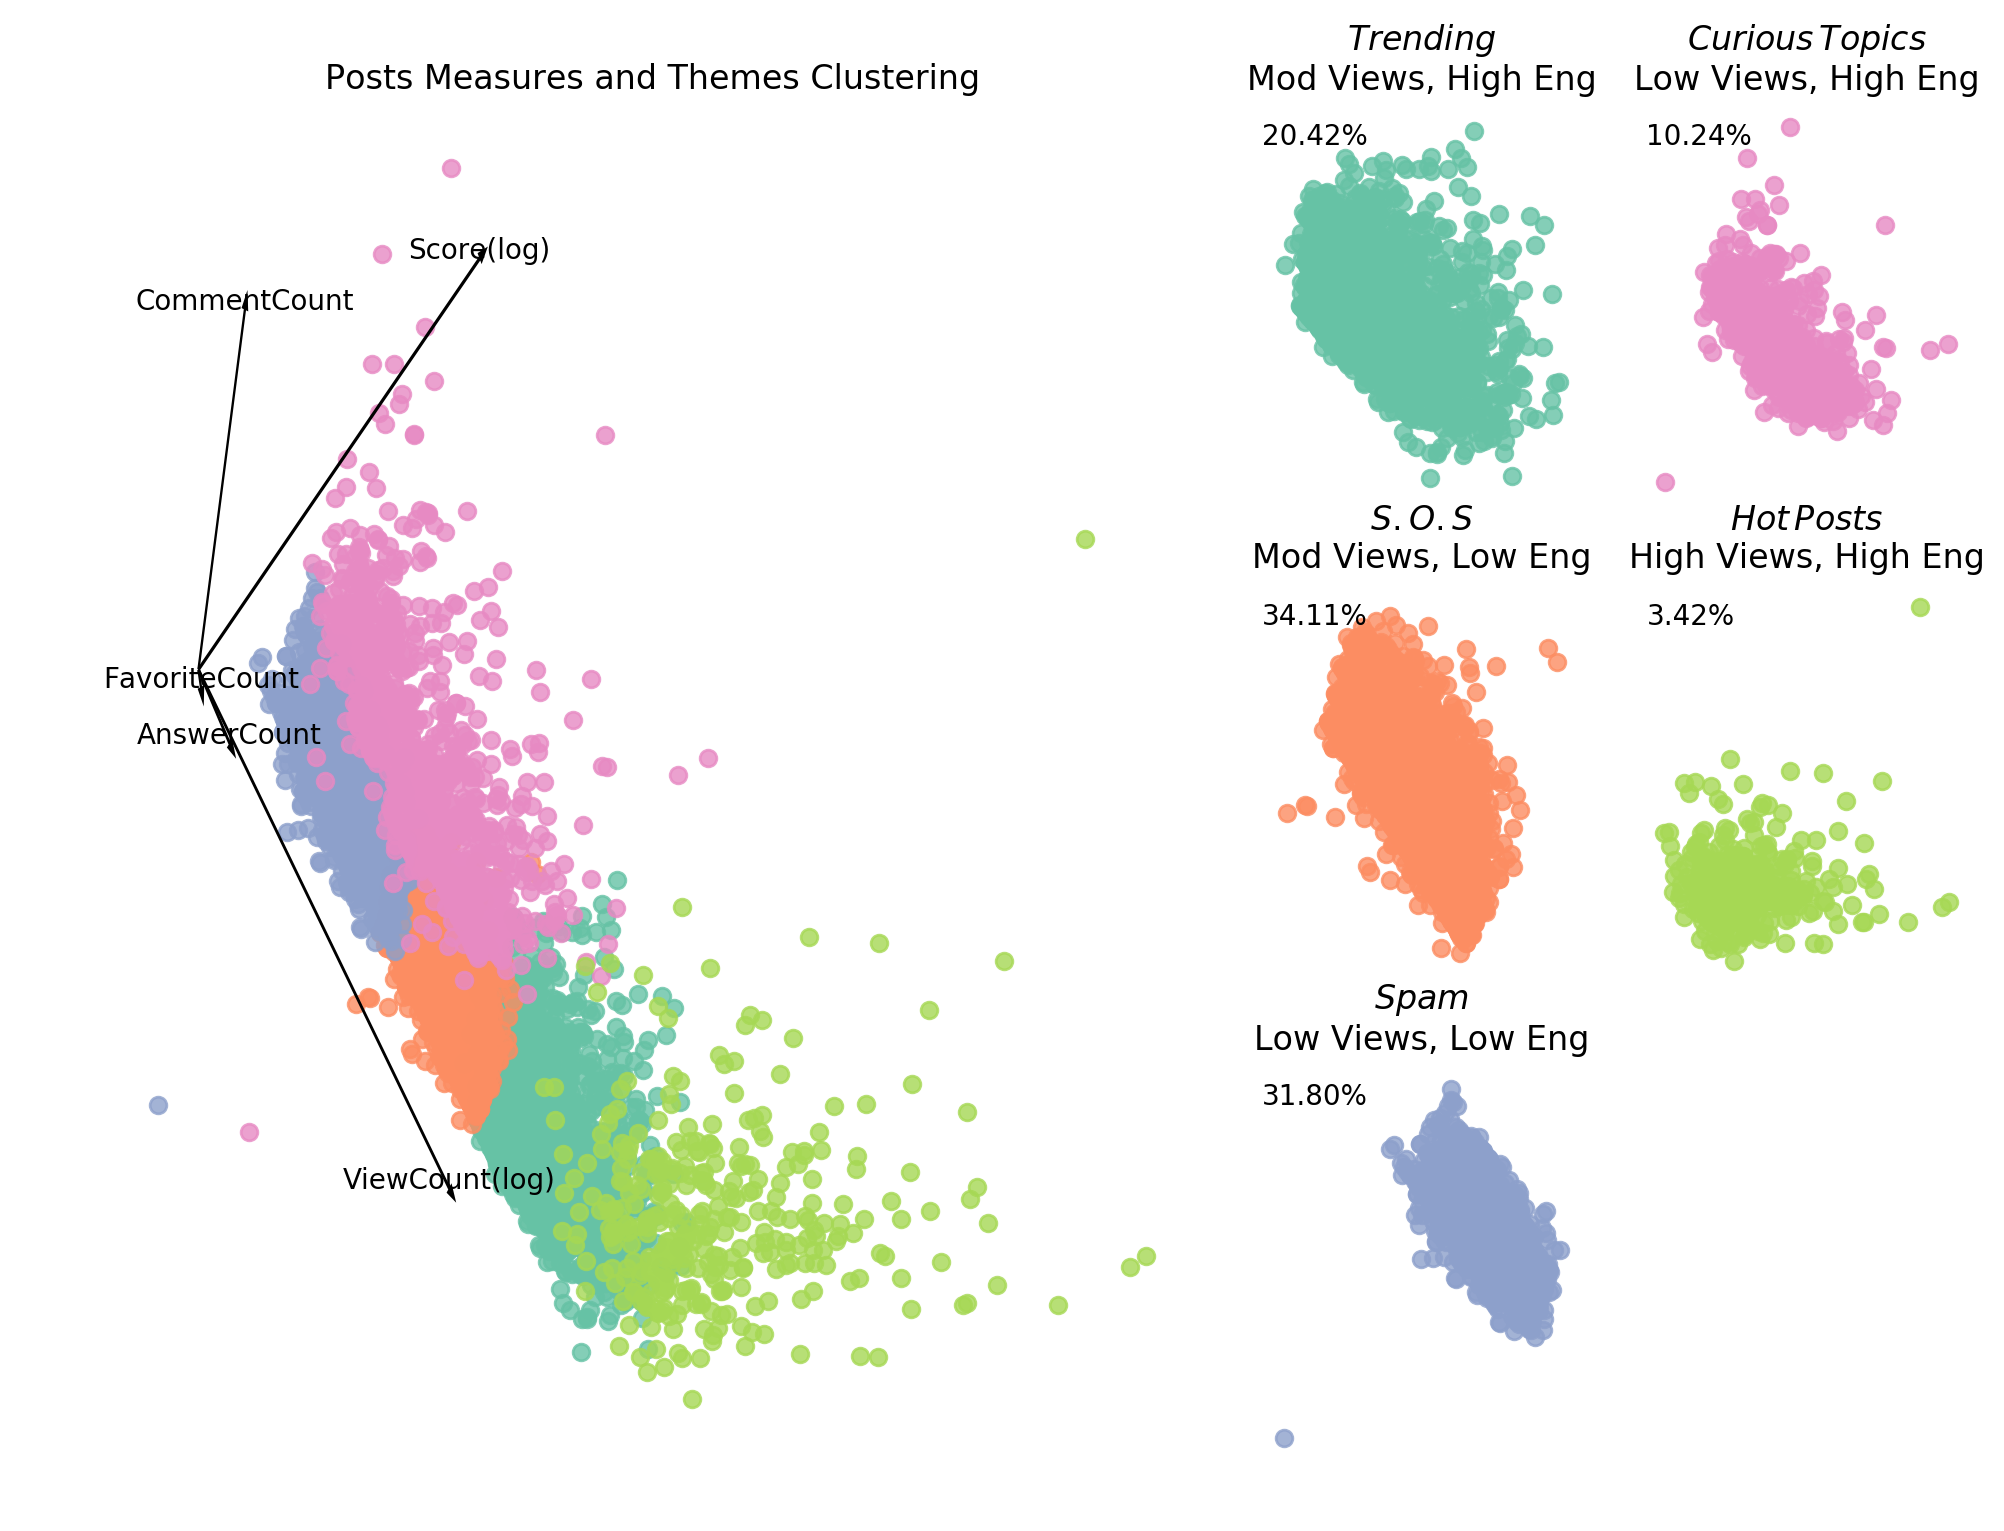

In [18]:
# Visualize the clusters from the truncated numerical design matrix

import matplotlib.cm as cm

colors = cm.Set2(range(5)) #set the colormap

k = 5
y = kmeans_cluster['ys'][k-k_start]

fig = plt.figure(figsize=(12, 9), dpi=200)
gs = gridspec.GridSpec(3, 5)
ax1 = plt.subplot(gs[:, :-2])

ax1.set_title('Posts Measures and Themes Clustering')

# Plot individually each cluster to manually set the colors
for i in range(max(y)+1):
    ax1.scatter(Xnum_trunc[:, 0][y == i], Xnum_trunc[:, 1]
                [y == i], alpha=0.8, c=colors[i])
ax1.set_axis_off()

# Plot the feature vectors
x0, y0 = 0.2, 0.2
s = 0.5
for feat, feat_name in zip(pca.components_.T, ['Score(log)', 'ViewCount(log)',
                                               'AnswerCount', 'CommentCount',
                                               'FavoriteCount']):
    ax1.arrow(x0, y0, s*feat[0], s*feat[1], color='k', width=0.003, ec='none')
    if not feat_name.endswith('(log)'):
        ax1.text(x0+s*feat[0], y0+s*feat[1], feat_name, ha='center',
                 color='k')
    else:
        ax1.text(x0+s*feat[0], y0+s*feat[1], feat_name, ha='center',
                 color='k')

# Plot the clusters individually and classify them
ax2 = plt.subplot(gs[0, 3])
ax2.scatter(Xnum_trunc[:, 0][y == 0], Xnum_trunc[:, 1]
            [y == 0], alpha=0.8, c=colors[0][None, :])
ax2.annotate(f'{(y==0).sum()*100/len(y):.2f}%',
             xy=(0, 0.9), xycoords='axes fraction')
ax2.set_title('$Trending$\nMod Views, High Eng')
ax2.set_axis_off()
ax3 = plt.subplot(gs[1, 3])
ax3.scatter(Xnum_trunc[:, 0][y == 1], Xnum_trunc[:, 1]
            [y == 1], alpha=0.8, c=colors[1][None, :])
ax3.annotate(f'{(y==1).sum()*100/len(y):.2f}%',
             xy=(0, 0.9), xycoords='axes fraction')
ax3.set_title('$S.O.S$\nMod Views, Low Eng')
ax3.set_axis_off()
ax4 = plt.subplot(gs[2, 3])
ax4.scatter(Xnum_trunc[:, 0][y == 2], Xnum_trunc[:, 1]
            [y == 2], alpha=0.8, c=colors[2][None, :])
ax4.annotate(f'{(y==2).sum()*100/len(y):.2f}%',
             xy=(0, 0.9), xycoords='axes fraction')
ax4.set_title('$Spam$\nLow Views, Low Eng')
ax4.set_axis_off()
ax5 = plt.subplot(gs[0, 4])
ax5.scatter(Xnum_trunc[:, 0][y == 3], Xnum_trunc[:, 1]
            [y == 3], alpha=0.8, c=colors[3][None, :])
ax5.annotate(f'{(y==3).sum()*100/len(y):.2f}%',
             xy=(0, 0.9), xycoords='axes fraction')
ax5.set_title('$Curious\,Topics$\nLow Views, High Eng')
ax5.set_axis_off()
ax6 = plt.subplot(gs[1, 4])
ax6.scatter(Xnum_trunc[:, 0][y == 4], Xnum_trunc[:, 1]
            [y == 4], alpha=0.8, c=colors[4][None, :])
ax6.annotate(f'{(y==4).sum()*100/len(y):.2f}%',
             xy=(0, 0.9), xycoords='axes fraction')
ax6.set_title('$Hot\,Posts$\nHigh Views, High Eng')
ax6.set_axis_off()

From these classifications, we can drill down into what the broad themes are across posts with different viewership and engagement levels.

### Non-numerical clustering
For each of the five clusters from the numerical features, the titles and tags in the stackoverflow post questions were used as features to identify the prominent topics for each cluster. However, performing the internal validation and clustering for all five clusters would take too much space and so, the non-numerical clustering will only be performed for one numerical cluster. The rest will be left in Appendix C. The output clusters will be stored in pickle files.

#### TF-IDF vectorizer

Since words have no concept of distance on their own, the posts must be vectorized. For this, TF-IDF is used. The post titles and post tags were separately vectorized.

For both titles and tags, a token pattern of `\w{2,}` is used, classifying words as those that have atleast two continuous word-characters in them. English stopwords were used from nltk. Moreover, the word `python` is redundant since the questions are already filtered to python posts. `using` and `use` are filtered since they are words that are frequent but not relevant.

The minimum document frequency (the percentage of documents a word must appear in for it to be considered a feature) is 0.001 for the titles and 0.01 for the tags.

Lastly, the weight of the features are binary, i.e. multiple occurrence of a word does not imply higher importance of the word.

From the EDA on non-numerical features, the body column adds too much information that is not necessary. As such, only the title and tags are used for this analysis.

In [19]:
# Vectorize the strings
stop_words = stopwords.words('english') + ['python', 'using', 'use']

tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}',
                                   stop_words=stop_words,
                                   binary=True,
                                   min_df=0.001)
X3_bow = tfidf_vectorizer.fit_transform(
    df_X0['Title'][kmeans_cluster['ys'][3] == 4])
tfidf_vectorizer_t = TfidfVectorizer(token_pattern='\w{2,}',
                                     stop_words=stop_words,
                                     binary=True,
                                     min_df=0.01)
X3_bow_t = tfidf_vectorizer_t.fit_transform(
    df_X0['Tags'][kmeans_cluster['ys'][3] == 4])

In [20]:
# Join the two design matrices
X3_data = np.concatenate((X3_bow.toarray(), X3_bow_t.toarray()), axis=1)

#### Dimensionality reduction

For the non-numerical clusters, dimensionality reduction is necessary not only for visualization but also for clustering to avoid overfitting and reduce the features for faster runtime. Two threshold number of features can be considered, the elbow point (left red line) and the 80% cumulative variance point (right red line). Note that in this particular case, there is no significant difference between the two points. And so, the matrix is truncated according to 80% cumulative variance explained.

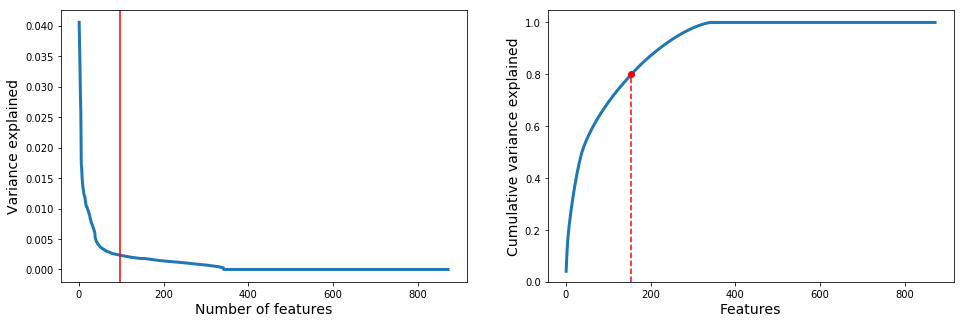

In [21]:
# Perform PCA on the non-numeric data
ax, n_PC = PC_analysis(X3_data);

In [22]:
# Truncate the data to n_PC, corresponding to 80% cumulative variance.
X3_bow_n = TruncatedSVD(n_components=int(n_PC)+1,
                        random_state=1337).fit_transform(X3_data)

#### Clustering

For the non-numerical clustering, K-Means clustering is also used. By normalizing the documents (which is the default for TF-IDF), the vectors can be imagined as constrained into a hypersphere. According to literature, cosine distance is best for text data since it ignores the length of the document. After normalizing, however, the effect of the document length is removed, making K-Means clustering (based on Euclidean distance) a good clustering algorithm for the text data.

In [23]:
# Perform internal validations on different number of clusters to obtain the
# optimal number of clusters
k_start, k_stop = (2, 10)
X3_kmeans_cluster = cluster_range(X3_bow_n, KMeans(random_state=1337), 
                               k_start=k_start, k_stop=k_stop)    

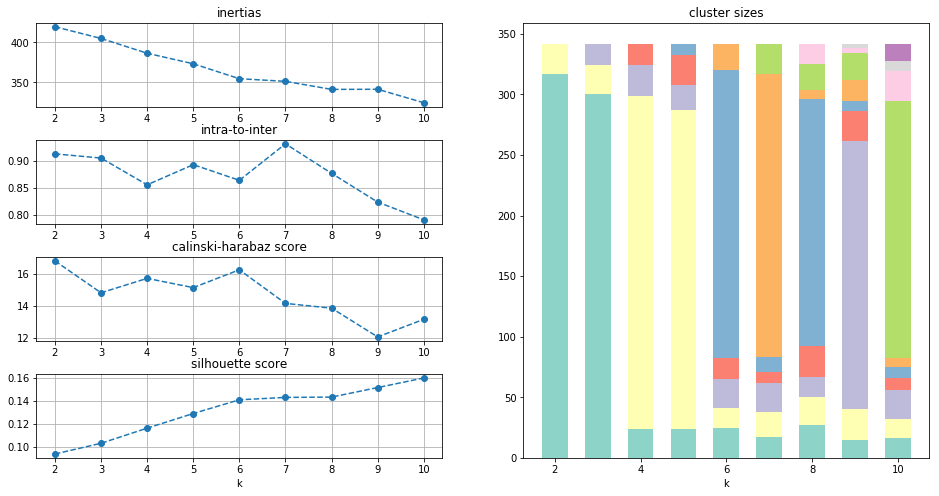

In [24]:
# Plot the resulting internal validation values
plot_internal(X3_kmeans_cluster, k_start=k_start, k_stop=k_stop);

From the internal validations, $k=6$ is chosen due to the high CH and silhouette while having low SSE and intra-to-inter ratio. There is a very large cluster, though, constituting more than two-thirds of the posts.

##### Clustering for one of the numerical clusters

To illustrate the results of the numerical clustering, a word cloud visualization of on of the identified clusters is shown below. In this particular illustration, the numerical cluster being analyzed is 'hot posts' cluster.

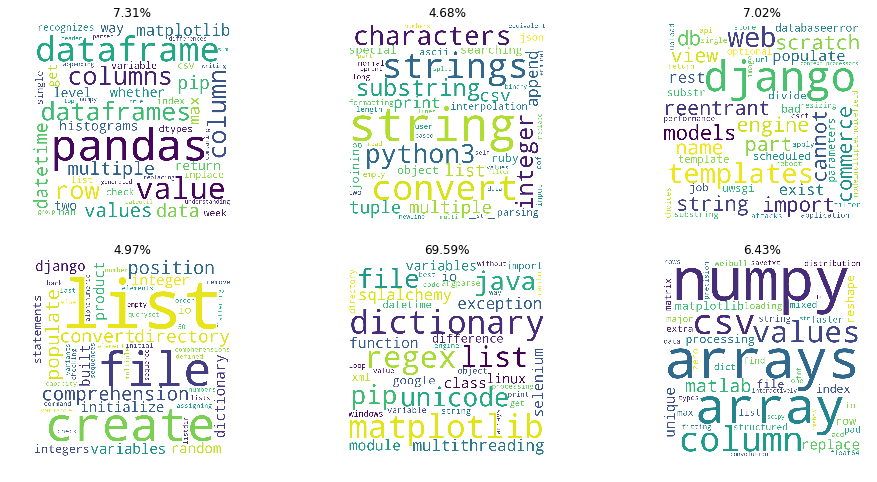

In [25]:
# Generate wordclouds of the features of the posts under each numeric cluster

from wordcloud import WordCloud
k = 6
y_kmeans = X3_kmeans_cluster['ys'][k-k_start]
fig, ax = plt.subplots(2, 3, figsize=(16,8))

# Get the proportions of the clusters
class_, count = np.unique(y_kmeans, return_counts=1)
for i in range(k):
    docs = X3_data[np.where(y_kmeans==i)[0]]
    dom_feat = np.argsort(docs.sum(axis=0))[::-1][:50]
    feat_wgt = docs.sum(axis=0)[dom_feat]
    dom_feat = np.array(tfidf_vectorizer.get_feature_names()
                        + tfidf_vectorizer_t.get_feature_names())[dom_feat]
    word_cld = {i[0]:int(i[1])+1 for i in zip(dom_feat, feat_wgt)}
    wordcloud = WordCloud(width = 800, height = 800, background_color='white',
                          collocations=False).generate_from_frequencies(word_cld)
    ax[i//3, i%3].imshow(wordcloud)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title(f'{100*count[i]/count.sum():.2f}%')

The wordcloud contains the most common features for each cluster. Note that the largest cluster contains several subtopics which can be further broken down into subclusters. The other clusters, on the other hand, are well-defined and usually pertains to a specific module or functionality of python.

## Resulting clusters and Insights

Appendix C details the process of extracting the most common features for each non-numerical subcluster, i.e. the themes that were found for each numerical cluster. Accessing the wordclouds generated, would illustrate the non-numerical subclustering that was implemented.

In [26]:
# Load the wordcloud files stored from Appendix C

path_ = '/mnt/processed/private/msds2020/lt13/pickle/james/'
wordcloud0 =  pickle.load(open(path_+'wordcloud0', 'rb'))
wordcloud1 =  pickle.load(open(path_+'wordcloud1', 'rb'))
wordcloud2 =  pickle.load(open(path_+'wordcloud2', 'rb'))
wordcloud3 =  pickle.load(open(path_+'wordcloud3', 'rb'))
wordcloud4 =  pickle.load(open(path_+'wordcloud4', 'rb'))

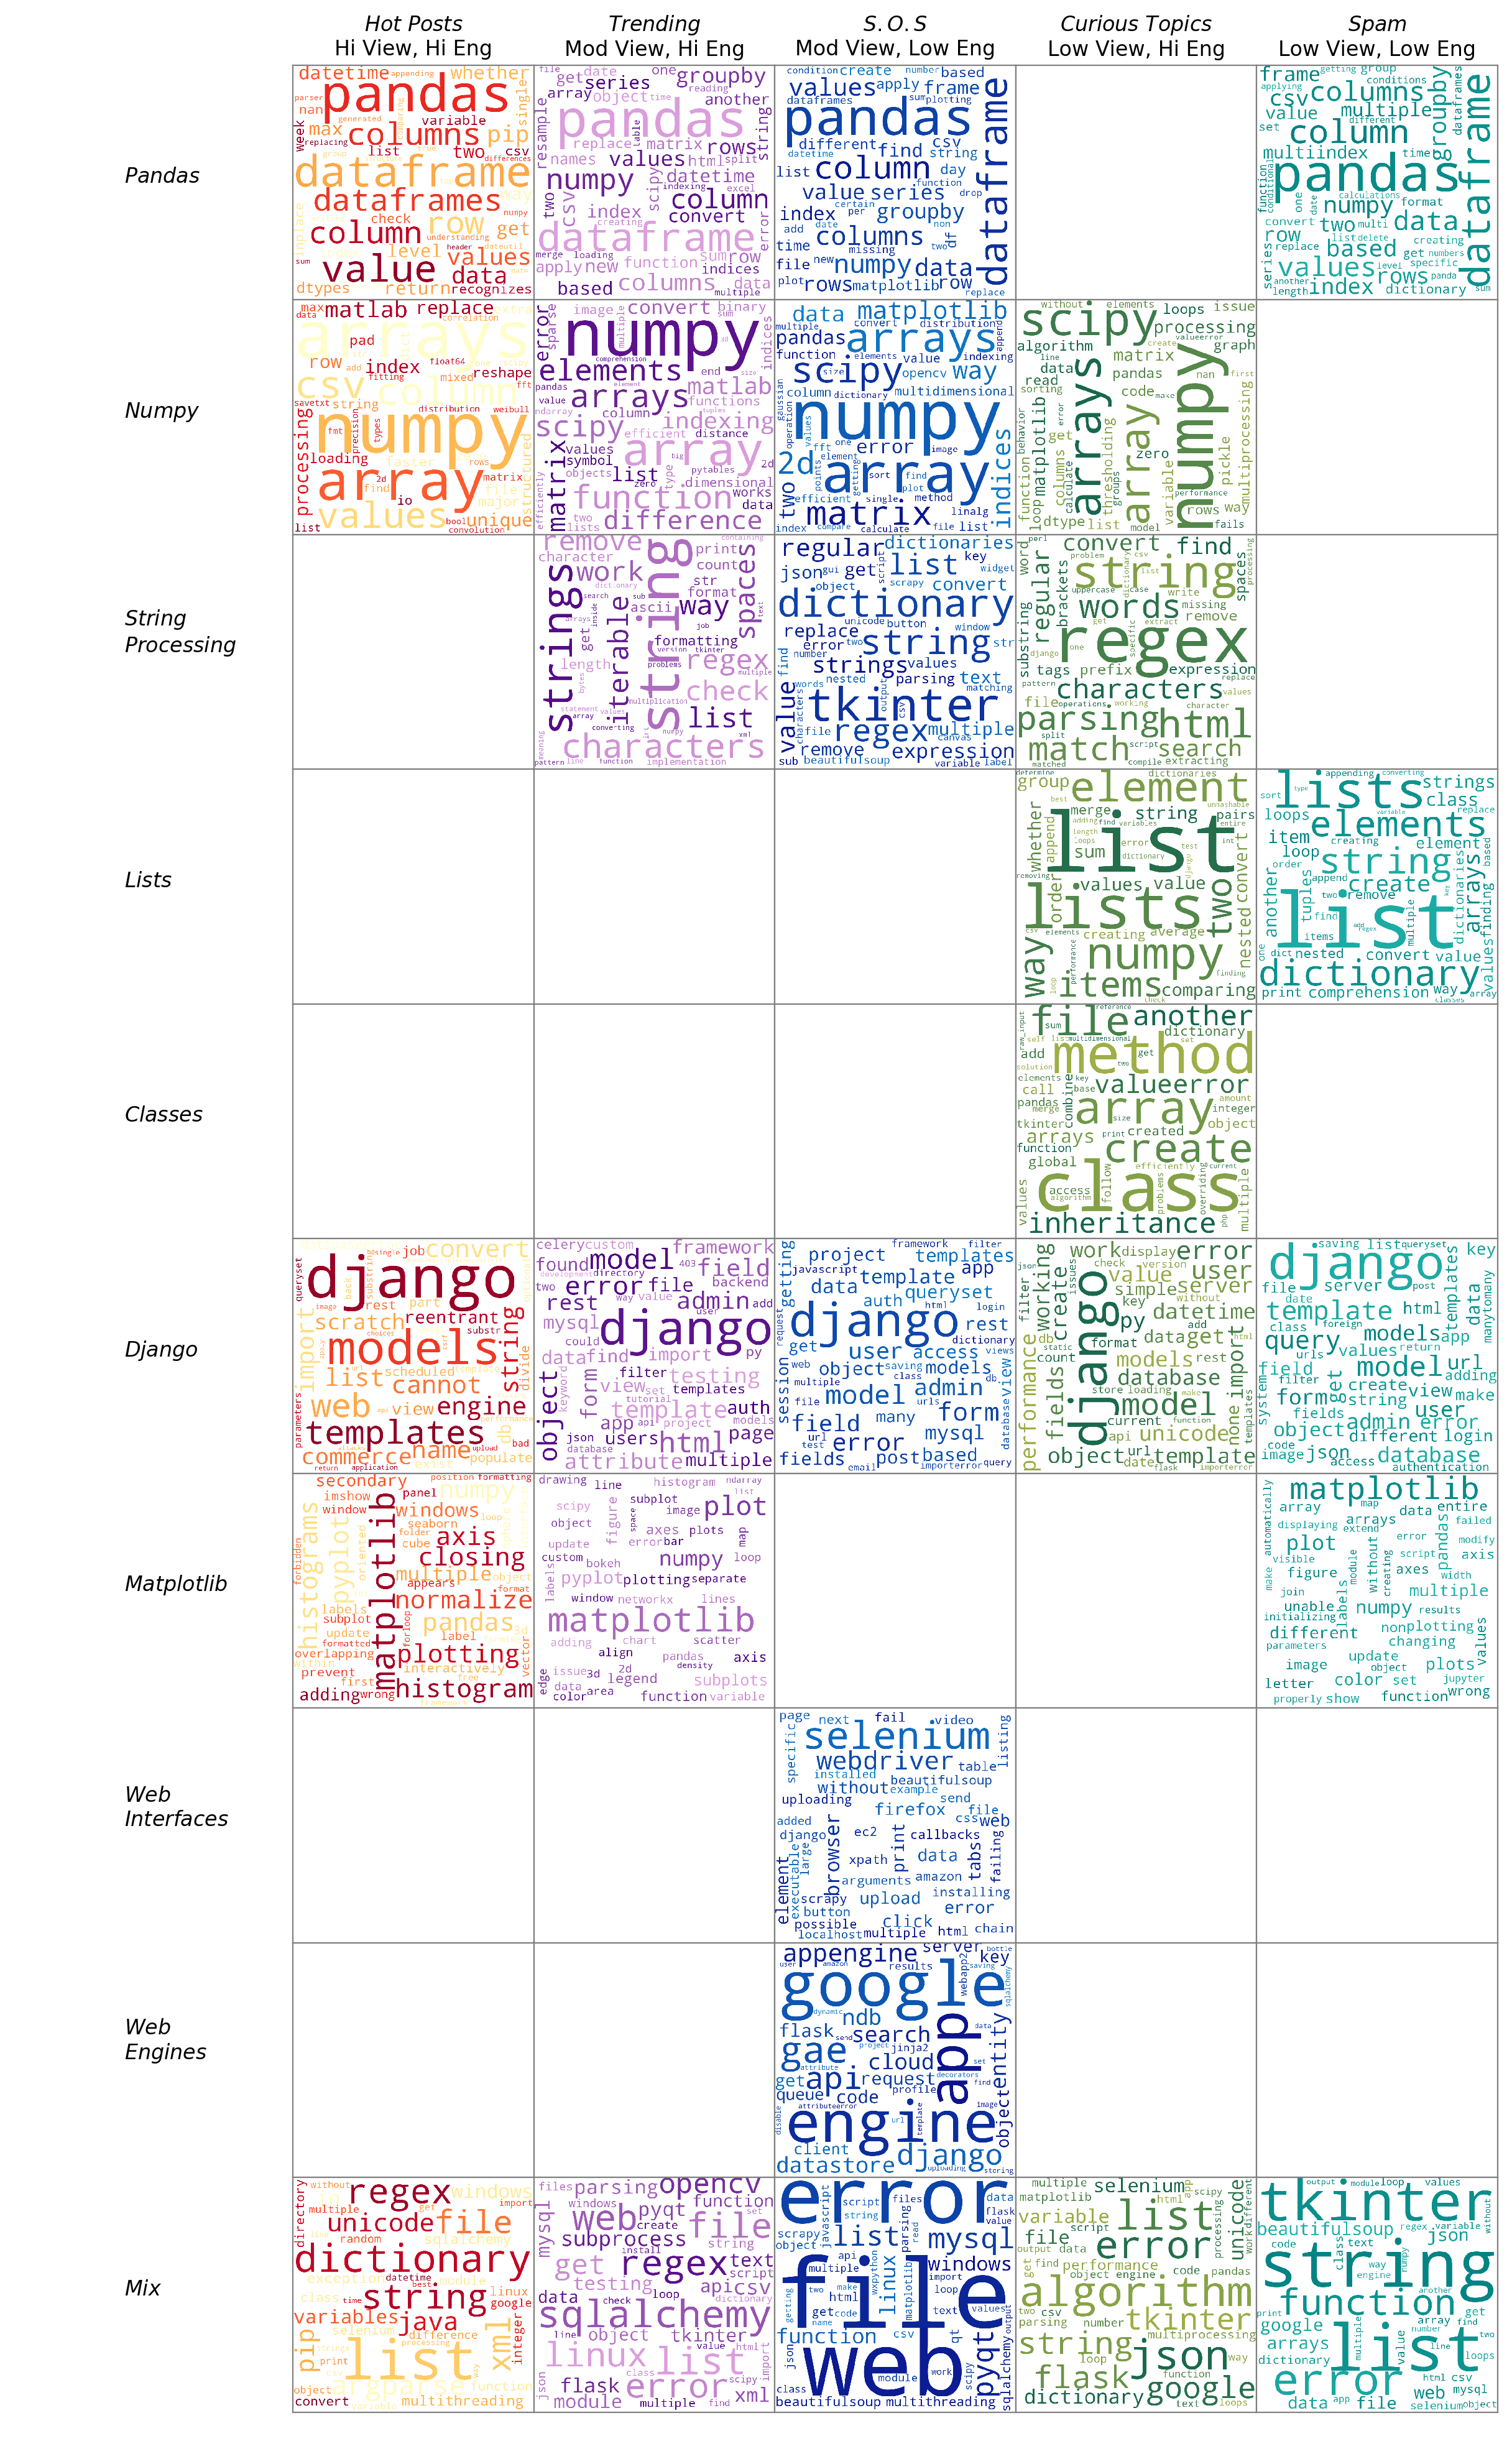

In [27]:
# Plot the wordclouds, taking into account that clusters on the same rows must
# have the same topics while the columns are the numeric clusters.

fig, ax = plt.subplots(10, 6, figsize=(15, 25), sharey=False, dpi=200)
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(10):
    ax[i, 0].set_axis_off()
    for j in range(1, 6):
        ax[i, j].spines['top'].set_color('Grey')
        ax[i, j].spines['left'].set_color('Grey')
        ax[i, j].spines['bottom'].set_color('Grey')
        ax[i, j].spines['right'].set_color('Grey')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
ax[0, 1].set_title('$Hot$ $Posts$\nHi View, Hi Eng')
ax[0, 2].set_title('$Trending$\nMod View, Hi Eng')
ax[0, 3].set_title('$S.O.S$\nMod View, Low Eng')
ax[0, 4].set_title('$Curious$ $Topics$\nLow View, Hi Eng')
ax[0, 5].set_title('$Spam$\nLow View, Low Eng')
ax[0, 1].imshow(wordcloud4[0], aspect='auto')
ax[9, 1].imshow(wordcloud4[1], aspect='auto')
ax[1, 1].imshow(wordcloud4[2], aspect='auto')
ax[5, 1].imshow(wordcloud4[3], aspect='auto')
ax[6, 1].imshow(wordcloud4[4], aspect='auto')
cmap_g = LinearSegmentedColormap.from_list('mycmap', ['#11644D', '#A0B046'])
ax[3, 4].imshow(wordcloud3[0].recolor(colormap=cmap_g), aspect='auto')
ax[2, 4].imshow(wordcloud3[1].recolor(colormap=cmap_g), aspect='auto')
ax[9, 4].imshow(wordcloud3[2].recolor(colormap=cmap_g), aspect='auto')
ax[5, 4].imshow(wordcloud3[3].recolor(colormap=cmap_g), aspect='auto')
ax[1, 4].imshow(wordcloud3[4].recolor(colormap=cmap_g), aspect='auto')
ax[4, 4].imshow(wordcloud3[5].recolor(colormap=cmap_g), aspect='auto')
cmap_p = LinearSegmentedColormap.from_list('mycmap', ['#DDA0DD', '#4B0082'])
cmap_b = LinearSegmentedColormap.from_list('mycmap', ['#107FC9', '#0B108C'])
cmap_bg = LinearSegmentedColormap.from_list('mycmap', ['#20B2AA', '#008080'])
ax[0, 2].imshow(wordcloud0[0].recolor(colormap=cmap_p), aspect='auto')
ax[5, 2].imshow(wordcloud0[1].recolor(colormap=cmap_p), aspect='auto')
ax[1, 2].imshow(wordcloud0[2].recolor(colormap=cmap_p), aspect='auto')
ax[6, 2].imshow(wordcloud0[3].recolor(colormap=cmap_p), aspect='auto')
ax[9, 2].imshow(wordcloud0[4].recolor(colormap=cmap_p), aspect='auto')
ax[2, 2].imshow(wordcloud0[5].recolor(colormap=cmap_p), aspect='auto')
ax[2, 3].imshow(wordcloud1[0].recolor(colormap=cmap_b), aspect='auto')
ax[7, 3].imshow(wordcloud1[1].recolor(colormap=cmap_b), aspect='auto')
ax[5, 3].imshow(wordcloud1[2].recolor(colormap=cmap_b), aspect='auto')
ax[9, 3].imshow(wordcloud1[3].recolor(colormap=cmap_b), aspect='auto')
ax[8, 3].imshow(wordcloud1[4].recolor(colormap=cmap_b), aspect='auto')
ax[0, 3].imshow(wordcloud1[5].recolor(colormap=cmap_b), aspect='auto')
ax[1, 3].imshow(wordcloud1[6].recolor(colormap=cmap_b), aspect='auto')
ax[6, 5].imshow(wordcloud2[0].recolor(colormap=cmap_bg), aspect='auto')
ax[0, 5].imshow(wordcloud2[1].recolor(colormap=cmap_bg), aspect='auto')
ax[9, 5].imshow(wordcloud2[2].recolor(colormap=cmap_bg), aspect='auto')
ax[5, 5].imshow(wordcloud2[3].recolor(colormap=cmap_bg), aspect='auto')
ax[3, 5].imshow(wordcloud2[4].recolor(colormap=cmap_bg), aspect='auto')
ax[0, 0].annotate('$Pandas$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[1, 0].annotate('$Numpy$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[2, 0].annotate('$String$\n$Processing$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[3, 0].annotate('$Lists$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[4, 0].annotate('$Classes$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[5, 0].annotate('$Django$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[6, 0].annotate('$Matplotlib$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[7, 0].annotate('$Web$\n$Interfaces$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[8, 0].annotate('$Web$\n$Engines$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12)
ax[9, 0].annotate('$Mix$', xy=(0.3, 0.5),
                  xycoords='axes fraction', fontsize=12);

From the wordclouds, we can see the common topics across posts of different levels of view and engagement. Based on the number of numerical clusters a topic is found in, the most common themes are: `django`, `pandas`, `numpy`, `matplotlib`, and `string processing`. Several insights can be further gleaned from this.

**On numerical clustering**

The numerical clustering has resulted to the following groups:`hot posts`,`Trending`,`S.O.S.`,`Curious Topics`,`Spam`. All of which were deduced from the user engagement each StackOverflow post has acquired - as represented by the numerical features attributed to each post. Looking into these, further implications may be deduced such as:

    1) Hot posts are always searched and discussed, meaning these are the most popular topics among programmers and enthusiasts. Under this cluster are pandas, numpy and matplotlib.

    2) Niche themes (S.O.S) are topics that are always searched in StackOverflow but have low user engagement such as Tkinter, Django, Selenium and Web Engines. We hypothesize that the low user engagement may be due to lack of experts on these topics. In particular, web interfaces and web engines topics are only found on this cluster, so the low number of experts may be even more applicable to these.

    3) On the opposite are Curious Topics which are not searched often but have high levels of engagement. A particular topic of focus is the class topic which corresponds to the object-oriented programming. This topic is generally not used by the general python learners, particularly the beginners, leading to the low views. However, due to the flexibility of classes, there is high engagement (therefore, it is part of Curious Topics). 

**On non-numerical clustering**


The non-numerical clustering is represented through the different rows presented in the Word Cloud above. This clustering was done based on the texts found within each post in the website. For row-wise analysis, the following are observed (per topic):

    1) Looking at the non-numerical clusters relative to the different numerical clusters, there is an apparent variation in the topics classified each groupings. For example for the numpy clusters, the `Trending`, `S.O.S`, and `Curious Topics` also have scipy along with numpy. However, for the `Hot` posts, the scipy feature is not visible. This can be attributed to the target of scipy which is the scientific community, a smaller proportion of the programming community. 

    2) Aside from the case of SciPy, string processing occurs for three different numerical clusters but the most frequent features vary. This is an artifact of the diverse functionalities of string processing, some more viewed than others. For example, the regex feature is very prominent in the Curious Topics which means it has low views but high engagement, implying that most posts on regex are not searched frequently but the questions posted about it have high number of answers, comments, etc, which is also due to the number of solutions to regex questions.

    3) Lastly, Django is a topic that is found across all the different levels of engagement. This ubiquity is due to how distinct Django is compared to other topics, making it easy to cluster.

## Conclusions and Recommendations

To summarize, Top "How To" topics in Python can be categorized into 5 namely: `Hot Post`, `Trending`, `S.O.S.`, `Curious Topics`, and `Spam`. The topics that were found in most of the 5 categories are `Pandas`, `NumPy`, `Django`, `Matplotlib`, and `String Processing`. There are topics that are endemic to one category like `Classes` but there are also those that are ubiquitous like `Django`. The following results may be attributed to the nature of each topic with regards to its user engagement. 

Looking at the numerical clustering as a representation of the user engagements, the following recommendations are drawn primarily on the premise of the demand for the answers on the topics classified under each clusters and the supply of questions on it. 

- **For students, it is recommended for them to focus learning the topics from `hot posts`.**
    
    This is because these posts yielded to high user engagement. Meaning, topics under which are the most frequently asked and thus reflect the most common concerns regarding Python. Nonetheless, these posts are also the ones with the most responses which would reflect that there is a rich literature and resources which students may refer to in clarifying their concerns.
    
- **For academicians, focus on building on the student's skills with respect to `hot posts` and develop dynamic curricula that builds on `S.O.S.`**
   
   As previously discussed, `hot posts` is suggestive of the general consensus with regards to the questions and clarifications with regards to Python. With this, in establishing the core competency of students in terms of programming, it is essential for these key topics to be well established and mastered by the students. 
    
    On the other hand, `S.O.S.` posts are those with a lot of views but with minimal enagement. Given this, it may be said that these are the questions that not much people are knowledgeable about but are in high demand. Hence, developing curricula on these would provide the students with a competitive advantage within the industry.
    
    
- **For professionals, focus on developing your skills based on `S.O.S.` and `Curious Topics`**
    
    As previously discussed, harnessing skills on the topics classified under `S.O.S.` provides an individual a competitive advantage compared to others who are using the same programming language. Moreover, developing on the `Curious Topics` are those with little views but with high engagement. These are the posts with a lot of ongoing discussion but with minimal searches - which may suggest recurring problems or niche topics. As a professional, mastering these would make one even more marketable against all other most especially since these topics are in high demand but with limited available references within StackOverflow.

In [63]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')